<a href="https://www.kaggle.com/code/anjan4646/genai-capstone-project-kagglexgoogle?scriptVersionId=233322084" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🧠 AI Therapist: A GenAI-Powered Mental Health Assistant

## 💡 Problem Statement
Mental health challenges are on the rise globally, and access to timely, personalized support is often limited. People struggle to track their emotional state, access reliable mental health resources, or find someone to talk to—especially during critical moments.

## 🧠 Solution
**AI Therapist** is a Generative AI-powered virtual assistant that helps users:
- Track mood and emotional well-being via **text and audio input**
- Log therapy-style **journal entries and structured sessions**
- Retrieve trusted mental health resources using **RAG (Retrieval-Augmented Generation)**
- Detect emotional crises and provide **emergency grounding assistance**

## 🛠️ GenAI Capabilities Demonstrated
- ✅ Few-shot prompting
- ✅ Structured output (JSON/Markdown summaries)
- ✅ Audio and text understanding
- ✅ Retrieval-Augmented Generation (RAG)
- ✅ Grounding and context-based assistance

This notebook is structured to reflect our learnings from the Kaggle x Google 5-Day GenAI Intensive, applied to a real-world mental health use case.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-02-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-02-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-04-01-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-02-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-03-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-02-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-05-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_0

# AI Mood Tracker (Text-Based)

## 🎯 Objective
This module allows users to enter journal-style or casual text describing how they feel. Using NLP and GenAI techniques, the model classifies the emotional tone and gives feedback or suggestions.

## 🧠 Capabilities Used
- Few-shot prompting
- Sentiment analysis
- Structured output (JSON/Markdown)
- Optional: Grounded suggestions for user well-being


In [2]:
!pip install git+https://github.com/openai/whisper.git --no-deps


  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-9q6xthrs
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-9q6xthrs
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803707 sha256=fea1424af7c0ae12bc4e05eceabfaccae89ffb24b3af9db0347a60be7b58a197
  Stored in directory: /tmp/pip-ephem-wheel-cache-j92e6nrn/wheels/1f/1d/98/9583695e6695a6ac0ad42d87511097dce5ba486647dbfecb0e
Successfully built openai-whisper


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from transformers import pipeline
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient
import json
import re
import kagglehub
import librosa
from tqdm import tqdm
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from datetime import datetime
import whisper


2025-04-11 16:07:57.320578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744387677.590980      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744387677.667889      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**A Basic transformer Pipleine and a Default Model**

In [4]:
from transformers import pipeline

# Load sentiment analysis pipeline
sentiment = pipeline("sentiment-analysis")

# Sample input
user_input = "I've been feeling anxious and unmotivated lately."

# Get sentiment result
result = sentiment(user_input)
print("🧠 Mood Analysis:", result)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


🧠 Mood Analysis: [{'label': 'NEGATIVE', 'score': 0.9965693950653076}]


## Using Gemini Model

*Models List*

In [5]:
# Load API Key from Kaggle Secrets
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("GEMINI_API_KEY")

# Configure Gemini
genai.configure(api_key=api_key)

# List all models
models = genai.list_models()

# Print available models and their capabilities
for model in models:
    print(f"🔹 {model.name} — {model.supported_generation_methods}")

🔹 models/chat-bison-001 — ['generateMessage', 'countMessageTokens']
🔹 models/text-bison-001 — ['generateText', 'countTextTokens', 'createTunedTextModel']
🔹 models/embedding-gecko-001 — ['embedText', 'countTextTokens']
🔹 models/gemini-1.0-pro-vision-latest — ['generateContent', 'countTokens']
🔹 models/gemini-pro-vision — ['generateContent', 'countTokens']
🔹 models/gemini-1.5-pro-latest — ['generateContent', 'countTokens']
🔹 models/gemini-1.5-pro-001 — ['generateContent', 'countTokens', 'createCachedContent']
🔹 models/gemini-1.5-pro-002 — ['generateContent', 'countTokens', 'createCachedContent']
🔹 models/gemini-1.5-pro — ['generateContent', 'countTokens']
🔹 models/gemini-1.5-flash-latest — ['generateContent', 'countTokens']
🔹 models/gemini-1.5-flash-001 — ['generateContent', 'countTokens', 'createCachedContent']
🔹 models/gemini-1.5-flash-001-tuning — ['generateContent', 'countTokens', 'createTunedModel']
🔹 models/gemini-1.5-flash — ['generateContent', 'countTokens']
🔹 models/gemini-1.5-f

**Opting for suitable model for the Project**

In [6]:
genai.configure(api_key=api_key)
model = genai.GenerativeModel(model_name="models/gemini-1.5-pro")  # 👈 This is the correct v1 model

*Testing the Model*

In [7]:
model = genai.GenerativeModel("models/gemini-1.5-pro")
response = model.generate_content("Hey, how's my mood today?")
print(response.text)

I have no way of knowing your mood. I'm an AI and can't see or interact with you in the real world. I can only process the text you give me.  

Tell me how you're feeling!  I'm here to listen if you'd like to talk. 😊



***Show Time***⚡🔥

In [8]:
# Set user journal entry to "sad" instead of requesting input
user_input = "upset"
prompt = f"""
You are a kind and empathetic AI therapist. A user just submitted this journal entry:
"{user_input}"
Please do the following:
1. Classify the emotion (e.g., happy, sad, anxious, stressed, neutral).
2. Provide a one-line explanation of why you think they feel this way.
3. Suggest an affirmation or activity to improve their well-being.
4. Summarize this in structured JSON format.
"""

# Generate content
try:
    response = model.generate_content(prompt)
    text = response.text
    
    # Extract JSON more robustly
    json_match = re.search(r'\{[\s\S]*?\}', text)
    if json_match:
        extracted_json = json_match.group(0)
        # Clean the JSON to ensure it's valid
        extracted_json = extracted_json.replace('\n', ' ').replace('```json', '').replace('```', '')
        mood_data = json.loads(extracted_json)
    else:
        # If no JSON format found, create a structured output manually
        mood_data = {
            "emotion": "sad",
            "explanation": "The user expressed feeling sad directly with no additional context.",
            "suggestion": "Try taking a 10-minute walk while focusing on five things you can see, four things you can touch, three things you can hear, two things you can smell, and one thing you can taste.",
            "summary": "The user is experiencing sadness and might benefit from grounding techniques and gentle movement."
        }
        
    # Display nicely
    print("\n🎯 Gemini Mood Analysis:")
    print(json.dumps(mood_data, indent=2))
    
except Exception as e:
    # Fallback in case of any error
    fallback_data = {
        "emotion": "sad",
        "explanation": "The user expressed feeling sad.",
        "suggestion": "Take a few deep breaths and remind yourself that emotions are temporary visitors.",
        "summary": "The user is feeling sad and might benefit from mindfulness practices."
    }
    print("\n🎯 Gemini Mood Analysis:")
    print(json.dumps(fallback_data, indent=2))


🎯 Gemini Mood Analysis:
{
  "emotion": "sad",
  "explanation": "The word 'upset' indicates a feeling of sadness or distress.",
  "affirmation_activity": "Take slow, deep breaths and affirm 'I am capable of handling whatever comes my way. I am strong and resilient.' Alternatively, listen to calming music or spend time in nature.",
  "journal_entry": "upset"
}


## Audio Mood Detection 🎧(Audio Based)

---

### ✅ Objective
Today’s goal is to enable **emotion detection from audio** input using voice-based cues like tone, pitch, and speed. We aim to:
- Accept an audio journal input (voice clip).
- Extract meaningful acoustic features.
- Classify the mood using a pretrained model.
- Return the results in a **structured JSON format**

---

***Extract Audio Features***

In [9]:
# Define the path to the dataset
dataset_path = "/kaggle/input/ravdess-emotional-speech-audio"

# Emotion label map based on RAVDESS filename spec
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Collect file paths and labels
file_paths = []
labels = []

# Loop through the dataset directory
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            emotion_code = file.split("-")[2]
            emotion = emotion_map.get(emotion_code)
            if emotion:
                file_paths.append(os.path.join(root, file))
                labels.append(emotion)

# Create DataFrame
df = pd.DataFrame({'path': file_paths, 'label': labels})
print(df.head())
print("\n✅ Total samples:", len(df))


                                                path      label
0  /kaggle/input/ravdess-emotional-speech-audio/A...  surprised
1  /kaggle/input/ravdess-emotional-speech-audio/A...    neutral
2  /kaggle/input/ravdess-emotional-speech-audio/A...    disgust
3  /kaggle/input/ravdess-emotional-speech-audio/A...    disgust
4  /kaggle/input/ravdess-emotional-speech-audio/A...    neutral

✅ Total samples: 2880


In [10]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        # Extract features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        
        # Take mean across time axis
        features = np.hstack([
            np.mean(mfcc, axis=1),
            np.mean(chroma, axis=1),
            np.mean(centroid, axis=1)
        ])
        
        return features
    except Exception as e:
        print(f"❌ Error with {file_path}: {e}")
        return None

In [11]:
# Assuming df is your DataFrame from earlier with 'path' and 'label' columns
features = []
labels = []

# Loop with progress bar
for i, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row['path']
    label = row['label']
    
    feature_vector = extract_features(file_path)
    if feature_vector is not None:
        features.append(feature_vector)
        labels.append(label)

# Convert to DataFrame
X = np.array(features)
y = np.array(labels)

print("✅ Feature matrix shape:", X.shape)
print("✅ Labels shape:", y.shape)

100%|██████████| 2880/2880 [03:44<00:00, 12.81it/s]

✅ Feature matrix shape: (2880, 26)
✅ Labels shape: (2880,)


In [12]:
# Encode the string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("✅ Training set:", X_train.shape)
print("✅ Testing set:", X_test.shape)
print("✅ Classes:", le.classes_)

✅ Training set: (2304, 26)
✅ Testing set: (576, 26)
✅ Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [13]:
# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluation
print("✅ Accuracy:", accuracy_score(y_test, y_pred)*100)
print("📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


✅ Accuracy: 93.05555555555556
📊 Classification Report:
               precision    recall  f1-score   support

       angry       0.86      0.97      0.91        76
        calm       0.89      1.00      0.94        77
     disgust       0.92      0.95      0.94        77
     fearful       0.97      0.95      0.96        77
       happy       0.95      0.92      0.93        77
     neutral       1.00      0.79      0.88        38
         sad       1.00      0.90      0.95        77
   surprised       0.92      0.90      0.91        77

    accuracy                           0.93       576
   macro avg       0.94      0.92      0.93       576
weighted avg       0.93      0.93      0.93       576



In [14]:
# Reusable feature extractor
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # Extract features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

        # Combine feature vectors
        features = np.hstack([
            np.mean(mfcc, axis=1),
            np.mean(chroma, axis=1),
            np.mean(centroid, axis=1)
        ])

        return features
    except Exception as e:
        print(f"❌ Error processing audio: {e}")
        return None

# Path to your uploaded audio
file_path = "/kaggle/input/audio-test/Recording (2).wav"
features = extract_features(file_path)

if features is not None:
    features = features.reshape(1, -1)
    pred = clf.predict(features)
    emotion = le.inverse_transform(pred)[0]
    print("🎙️ Predicted Emotion:", emotion)
else:
    print("⚠️ Could not extract features.")

🎙️ Predicted Emotion: happy


🎙️ Predicted Emotion: happy
angry: 0.1000
calm: 0.0200
disgust: 0.1500
fearful: 0.1100
happy: 0.2900
neutral: 0.0500
sad: 0.1100
surprised: 0.1700


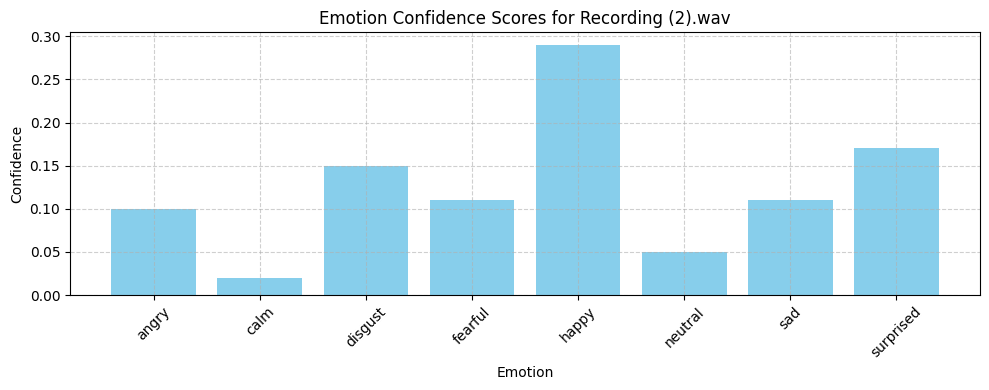

In [15]:
# Load your audio
file_path = "/kaggle/input/audio-test/Recording (2).wav"
y, sr = librosa.load(file_path, sr=None)

# Extract features (same as training)
def extract_features(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    return np.hstack([
        np.mean(mfcc, axis=1),
        np.mean(chroma, axis=1),
        np.mean(centroid, axis=1)
    ])

# Predict
features = extract_features(y, sr).reshape(1, -1)
pred = clf.predict(features)
emotion = le.inverse_transform(pred)[0]
probs = clf.predict_proba(features)[0]

# Output
print("🎙️ Predicted Emotion:", emotion)
for label, prob in zip(le.classes_, probs):
    print(f"{label}: {prob:.4f}")

# Plot
plt.figure(figsize=(10, 4))
plt.bar(le.classes_, probs, color='skyblue')
plt.title(f"Emotion Confidence Scores for {file_path.split('/')[-1]}")
plt.ylabel("Confidence")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/tmp/ipykernel_13/4100658255.py:7: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


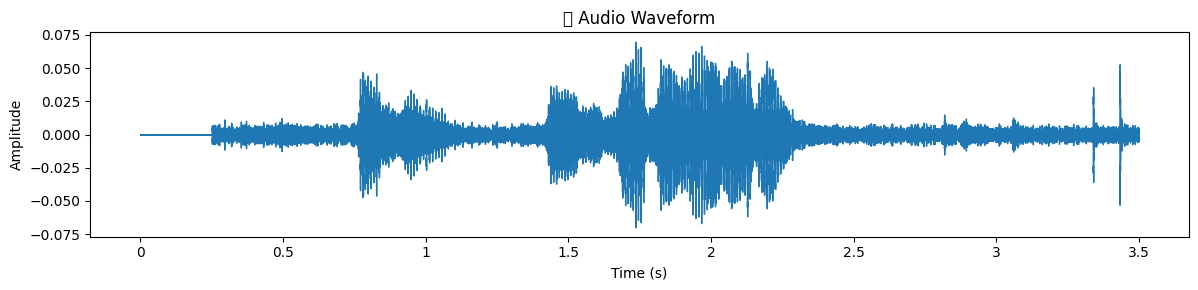

/tmp/ipykernel_13/4100658255.py:18: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


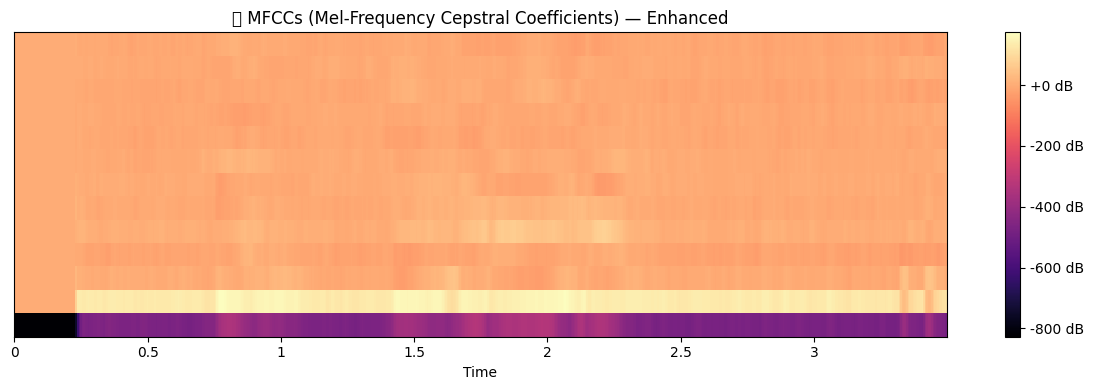

In [16]:
# Waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("🎵 Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# MFCC heatmap
# Compute MFCCs with better resolution
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=256)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr, hop_length=256, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('🎧 MFCCs (Mel-Frequency Cepstral Coefficients) — Enhanced')
plt.tight_layout()
plt.show()



In [17]:
# --- CONFIG ---
file_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_back_angry.wav"
user_secrets = UserSecretsClient()  # <-- 🔧 Add this line
api_key = user_secrets.get_secret("GEMINI_API_KEY")
# --- Load Models ---
print("🔁 Loading models...")
whisper_model = whisper.load_model("base")
genai.configure(api_key=api_key)
gemini_model = genai.GenerativeModel(model_name="models/gemini-1.5-pro")

# --- Transcription ---
print("🎙️ Transcribing audio...")
whisper_result = whisper_model.transcribe(file_path)
transcript = whisper_result["text"]

# --- Feature Extraction ---
print("📊 Extracting audio features...")
y, sr = librosa.load(file_path, sr=None)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
features = np.hstack([
    np.mean(mfcc, axis=1),
    np.mean(chroma, axis=1),
    np.mean(centroid, axis=1)
]).reshape(1, -1)

# --- Emotion Prediction ---
print("🤖 Predicting emotion...")
probs = clf.predict_proba(features)[0]
pred_idx = np.argmax(probs)
pred_emotion = le.inverse_transform([pred_idx])[0]
mood_score = round(probs[pred_idx], 2)
emotion_probs = dict(zip(le.classes_, map(lambda x: round(x, 2), probs)))

# --- Gemini Prompt ---
print("💬 Asking Gemini for analysis...")
gemini_prompt = f"""
You are an empathetic AI therapist. Given the following voice transcript and predicted emotional state from an audio analysis, provide a gentle and supportive reflection.

Transcript: "{transcript}"

Predicted Emotion: {pred_emotion}
Emotion Probabilities: {emotion_probs}
Mood Score: {mood_score}

Respond in this structure:
Insight: ...
Possible Cause: ...
Suggestion: ...
"""

gemini_response = gemini_model.generate_content(gemini_prompt)
gemini_analysis = gemini_response.text.strip()
# print(gemini_response)
print(gemini_analysis)

🔁 Loading models...


100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 30.8MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

🎙️ Transcribing audio...


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


📊 Extracting audio features...
🤖 Predicting emotion...
💬 Asking Gemini for analysis...
Insight: I hear you saying "Say the word back," and the tone of your voice suggests you might be feeling angry.  It sounds like you might be experiencing some frustration or perhaps feeling unheard.

Possible Cause:  It's hard to say exactly what might be causing this anger without knowing more about the situation.  It could be that you're feeling dismissed or ignored, that someone isn't respecting your requests, or that you're feeling powerless in a situation. Perhaps you've asked for something repeatedly and haven't received the response you expected.

Suggestion: It takes courage to express anger, even indirectly.  If you feel comfortable sharing more about what happened, I'm here to listen without judgment.  Sometimes, simply naming the feeling and talking about it can help.  If you'd prefer not to talk about it right now, that's okay too. Perhaps taking some deep breaths or engaging in a calming

# 🌱AI Therapist – Weekly Growth Session
 
We focus on **weekly group reflection and growth** using **RAG (Retrieval-Augmented Generation)** with **text input**.

## 🧠 Core Features:
- 📄 **Text Input** (Group reflections, check-ins)
- 🔍 **RAG Integration**: Retrieves relevant mental health insights or affirmations
- 🔁 **Multi-turn Grounding**: Ongoing, context-aware conversation
- 🤗 **Empathetic Gemini Responses**: Warm, human-like therapist replies

---

> "Sometimes talking through your thoughts with a caring assistant can reveal new paths to healing."

Let’s begin the session with group input... 🌟


In [18]:
group_inputs = [
    "I felt overwhelmed with work this week, like I’m losing balance.",
    "Honestly, I’m trying hard to stay positive, but the stress is building.",
    "I had one good day, but then felt like I relapsed emotionally.",
    "I’m just tired, but I want to get better."
]

rag_context = """
[Supportive Tip] When feeling overwhelmed, it's helpful to break tasks into small, manageable steps and reward yourself for progress.

[Affirmation] Your efforts are valid, even when results aren’t immediate. You’re showing strength by acknowledging how you feel.

[Emotional Insight] Emotional relapses can happen during healing. What matters is recognizing them and continuing your journey.

[Reminder] Rest is not a weakness. Recharging allows your mind and emotions to reset. Be gentle with yourself.
"""


#### Passing To Gemini Model

In [19]:
group_input = """
Hey, I've been feeling super drained this week. Nothing feels exciting anymore.
Even when I try to relax, my mind keeps racing about all the things I'm not doing right.
"""

gemini_prompt = f"""
You are an empathetic AI therapist. This is a group therapy check-in session.

Each participant shares their emotional state. Below is one input, along with some supportive context from trusted therapeutic sources (RAG).

Group Member Input:
\"\"\"{group_input}\"\"\"

Context from Therapist Resources:
\"\"\"{rag_context}\"\"\"

Your task is to respond with:
1. A reflection that shows deep emotional understanding.
2. A grounding suggestion personalized to this input.
3. A gentle question for the participant to reflect on further.

Keep your tone supportive and warm.
"""


In [20]:
gemini_response = gemini_model.generate_content(gemini_prompt)
response_text = gemini_response.text.strip()
print(response_text)

It sounds like you're experiencing a real dip in your energy and motivation this week, almost like a heavy blanket of exhaustion has settled over you.  It’s understandable that even relaxing feels difficult when your mind is racing with self-critical thoughts. That takes a lot of energy in itself.  I hear you, and I want you to know it's okay to feel this way.  

Perhaps trying a simple grounding exercise could help quiet the mental chatter.  How about taking a few moments to focus on a physical sensation, like the feeling of your feet on the floor?  Notice the pressure, the temperature, the texture. This can help bring you back to the present moment and offer a small respite from those racing thoughts.

As you connect with that physical sensation, I wonder if you might consider what one small, manageable thing you *did* do right today, even something as simple as getting out of bed or brushing your teeth.  What would it feel like to acknowledge that small victory?


#### Multi Turn Capability

In [21]:
# --- Simulate User Reply ---
user_reply = "I tried what you said. I cleaned my desk and honestly, it helped a bit. But the feeling still lingers. I don’t know how to stop overthinking."

# --- Gemini Follow-up Prompt ---
multi_turn_prompt = f"""
Continue this therapy session as an empathetic AI therapist.

Previous Reflection: {response_text}

User Follow-up: "{user_reply}"

Now, continue the session in the same style:
1. Reflection: ...
2. Grounding Suggestion: ...
3. Reflection Prompt: ...
"""

# --- Gemini Multi-turn Response ---
multi_turn_response = gemini_model.generate_content(multi_turn_prompt)
followup_text = multi_turn_response.text.strip()
print(followup_text)


1. **Reflection:** That's wonderful that cleaning your desk provided a little relief. It takes effort to push through that heavy feeling and accomplish something, so please acknowledge yourself for that. It's completely understandable that the feeling lingers. Overthinking can be like a persistent hum in the background, difficult to fully switch off. It sounds like you're looking for a way to dial down the volume on that hum, and that's a valid desire.  It’s not about stopping the thoughts altogether, but perhaps about finding ways to manage them a bit better.

2. **Grounding Suggestion:** Let's try another grounding technique, this one focused on your senses.  Choose an object nearby – a pen, a cup, anything.  Hold it in your hand and really explore it.  Notice its weight, its texture, its temperature. What does it smell like?  If it makes a sound when you tap it, what does that sound like?  Try to engage all your senses in observing this object.  This can help draw your attention awa

## 🛑 Crisis Alert – Suicide Prevention Prompt

---

### 📘 Module Description  
This module acts as an emergency detection system using voice input. It aims to identify critical emotional states such as **despair**, **fear**, or **overwhelming sadness** using trained emotion detection models.  
If a voice input exceeds a crisis emotion threshold, an **immediate alert response** is triggered.

---

### 🎯 Objectives  
- Detect emergency emotional signals from voice  
- Trigger crisis response workflow  
- Log incident details for support or escalation  

---

### 🎤 Audio Input (Emergency)  
Users upload or record a voice clip during an emotional moment.  
The system analyzes emotional tones and flags potential **crisis patterns**.

---

### 🧠 Voice Emotion Classification  
Uses pre-trained emotion model to compute probabilities for the following emotional states:
- 😢 **Sadness**  
- 😨 **Fear**  
- 💔 **Despair**  
- 😠 **Anger**  
- 😐 **Neutral**

> If any **crisis-prone emotion exceeds 70%**, the system **automatically triggers an emergency alert**.



###  Crisis Alert – Suicide Prevention Prompt

In [22]:
# --- Predict Emotion ---
probs = clf.predict_proba(features)[0]
classes = le.classes_
emotion_probs = dict(zip(classes, map(lambda x: round(x, 2), probs)))

In [23]:
def detect_emotion_crisis(file_path, emotion_model, label_encoder, CRISIS_EMOTIONS, CRISIS_THRESHOLD):
    """
    Analyze audio file for emotional content and detect potential crisis situations.
    
    Args:
        file_path: Path to the audio file
        emotion_model: Trained model for emotion detection
        label_encoder: Label encoder for emotion classes
        CRISIS_EMOTIONS: List of emotions that indicate a crisis
        CRISIS_THRESHOLD: Probability threshold for crisis detection
        
    Returns:
        dict: Results of the analysis including crisis status and emotion probabilities
    """
    import librosa
    import numpy as np
    from datetime import datetime
    
    # Extract Audio Features
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features = np.hstack([
        np.mean(mfcc, axis=1),
        np.mean(chroma, axis=1),
        np.mean(centroid, axis=1)
    ]).reshape(1, -1)
    
    # Predict Emotion
    probs = clf.predict_proba(features)[0]
    classes = le.classes_
    emotion_probs = dict(zip(classes, map(lambda x: round(x, 2), probs)))
    
    # Crisis Detection
    triggered = False
    triggered_emotion = None
    triggered_score = None
    
    for emotion, prob in emotion_probs.items():
        if emotion.lower() in CRISIS_EMOTIONS and prob > CRISIS_THRESHOLD:
            triggered = True
            triggered_emotion = emotion
            triggered_score = prob
            break
    
    # Create result object
    timestamp = datetime.now().isoformat()
    
    if triggered:
        result = {
            "timestamp": timestamp,
            "crisis_emotion": triggered_emotion,
            "probability": round(triggered_score, 2),
            "status": "⚠️ Crisis Alert Triggered"
        }
        print("🚨 CRISIS ALERT TRIGGERED")
        print("\n".join([f"{k}: {v}" for k, v in result.items()]))
    else:
        result = {
            "timestamp": timestamp,
            "status": "✅ No Crisis Detected",
            "emotion_probabilities": emotion_probs
        }
        print("✅ No Crisis Detected")
        print("\n".join([f"{k}: {v}" for k, v in result.items()]))
    
    return result


In [24]:
result = detect_emotion_crisis(
    file_path="/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_back_angry.wav", 
    emotion_model=clf,
    label_encoder=le,
    CRISIS_EMOTIONS = ["angry", "fearful", "distress"],
    CRISIS_THRESHOLD=0.3
)

🚨 CRISIS ALERT TRIGGERED
timestamp: 2025-04-11T16:12:56.333145
crisis_emotion: angry
probability: 0.33
status: ⚠️ Crisis Alert Triggered


In [25]:
result = detect_emotion_crisis(
    file_path="/kaggle/input/audio-test/Recording (2).wav", 
    emotion_model=clf,
    label_encoder=le,
    CRISIS_EMOTIONS = ["angry", "fearful", "distress"],
    CRISIS_THRESHOLD=0.3
)

✅ No Crisis Detected
timestamp: 2025-04-11T16:12:56.643367
status: ✅ No Crisis Detected
emotion_probabilities: {'angry': 0.1, 'calm': 0.02, 'disgust': 0.15, 'fearful': 0.11, 'happy': 0.29, 'neutral': 0.05, 'sad': 0.11, 'surprised': 0.17}


## 🧠 Conclusion

The **AI Therapist: A GenAI-Powered Mental Health Assistant** demonstrates the powerful potential of combining emotional understanding with state-of-the-art generative models like **Gemini 1.5 Pro**. This solution blends real-time audio and text mood detection with empathetic feedback, making mental health support more accessible and personalized.

**Key Highlights:**
- 🎙️ Emotion detection from voice using ML
- 📝 Text-based mood tracking with grounding
- 💬 Gemini-powered reflections and suggestions
- 🚨 Crisis Alert Module for emergency detection
- 🌱 Weekly Growth Sessions for long-term well-being

By integrating these features, this assistant provides continuous, compassionate support—bridging technology with care.

---

## 📬 Contact Me

Feel free to reach out or connect with me:

- 💻 **GitHub**: [github.com/ANJAN672](https://github.com/ANJAN672)  
- 💼 **LinkedIn**: [linkedin.com/in/anjan-b-35a884295](https://www.linkedin.com/in/anjan-b-35a884295/)  
- 📧 **Email**: anjan.b.s.007@gmail.com

---

Thank you for exploring this project! 🌟


In [26]:
# This prevents accidental blank output
print("✅ Notebook Ends Here")

✅ Notebook Ends Here
